In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

In [2]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.3.1
Eager mode:  True
Hub version:  0.10.0
GPU is available


In [3]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

In [4]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

train_examples[:10]
train_labels[:10]

Training entries: 25000, test entries: 25000


array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0], dtype=int64)

In [5]:
model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
# model = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(model, output_shape=[20], input_shape=[], 
                           dtype=tf.string, trainable=True)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [7]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 2s 62ms/step - loss: 1.1038 - accuracy: 0.5280 - val_loss: 0.6904 - val_accuracy: 0.5607
Epoch 2/20
30/30 [==============================] - 2s 55ms/step - loss: 0.6789 - accuracy: 0.5783 - val_loss: 0.6597 - val_accuracy: 0.6151
Epoch 3/20
30/30 [==============================] - 2s 56ms/step - loss: 0.6412 - accuracy: 0.6439 - val_loss: 0.6314 - val_accuracy: 0.6532
Epoch 4/20
30/30 [==============================] - 2s 56ms/step - loss: 0.6105 - accuracy: 0.6800 - val_loss: 0.6031 - val_accuracy: 0.6905
Epoch 5/20
30/30 [==============================] - 2s 56ms/step - loss: 0.5799 - accuracy: 0.7122 - val_loss: 0.5754 - val_accuracy: 0.7153
Epoch 6/20
30/30 [==============================] - 2s 55ms/step - loss: 0.5494 - accuracy: 0.7383 - val_loss: 0.5482 - val_accuracy: 0.7378
Epoch 7/20
30/30 [==============================] - 2s 57ms/step - loss: 0.5181 - accuracy: 0.7661 - val_loss: 0.5172 - val_accuracy: 0.7614
Epoch 8/20
30

In [8]:
results = model.evaluate(test_data, test_labels)

print(results)

782/782 [==============================] - 3s 4ms/step - loss: 0.3191 - accuracy: 0.8644
[0.31910908222198486, 0.8644000291824341]


In [9]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

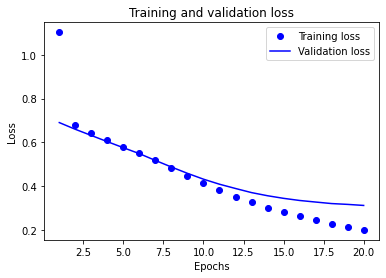

In [10]:
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

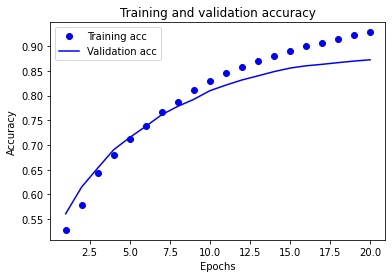

In [11]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [12]:
pred = model.predict(test_data)

In [13]:
bin_pred = []
rng = list(range(0, 64))
rng.extend(list(range(65, 101)))
num = len(rng)
for p in [pred[x] for x in rng]:
    if p < 0:
        bin_pred.append(0)
    else:
        bin_pred.append(1)

In [14]:
comp = []
for idx, p in enumerate(bin_pred):
    comp.append(abs(p - test_labels[rng[idx]]))

(num - sum(comp))/num

0.82

In [15]:
inc_val = np.zeros(len(comp))
for i, c in enumerate(comp):
    if c:
        inc_val[i] = pred[i]

In [16]:
max(inc_val)

3.961634397506714

In [17]:
min(inc_val)

-4.261927604675293

In [18]:
test_examples[np.argmax(inc_val)]

b'Count Laszlo (Ralph Fiennes) has just been transferred to a hospital in Italy during World War II. He is horrifically burned from an ambush. His nurse Hana (Juliette Binoche) tends to him, body and mind, for she fears, quite rightly, that he may be a very troubled soul. In the course of his care, the Count starts to tell Hana of his recent past. It seems he worked in a government capacity in Africa, where he met a beautiful married lady named Katherine (Kristin Scott Thomas). Although they tried to avoid each other, they fell in love. After a brief affair, Katherine called it quits, leaving the Count desolate. Even so, the two would meet again, under heart-wrenching circumstances. Meanwhile, Hana herself falls for a Sihk man in the British bomb squad. Yet, the war is raging relentlessly. Can love exist when the world is in turmoil? This is a tremendous film, based on an equally fine but complex novel. The plot has many story lines that are woven together beautifully, each of them poi

In [19]:
test_labels[np.argmax(inc_val)]

1

In [20]:
bin_pred[np.argmax(inc_val)]

0

In [21]:
test_examples[np.argmin(inc_val)]

b'I happened to catch this on TV, and wanted to watch because I remembered the Spin magazine article upon which the movie is based. I was very disappointed. First, if James Belushi is the lead actor in a movie, it should be a sign that it\'s not exactly an A-list production. Gregory Hines was a world class dancer, but sadly not a great actor.<br /><br />In fact, all of the acting in this film is either flat or hammy, which can only be blamed on the director, who is this film\'s weakest link. Charles Carner seemed to be trying to ape Oliver Stone\'s "JFK" in portraying the alleged conspiracy to cover up the "real" child murderer(s), but without the benefit of a good script, an A-list cast or, it must be said, the talent. It just doesn\'t work.<br /><br />It\'s a shame that such a worthy topic for a film did not get better treatment.'

In [22]:
test_labels[np.argmin(inc_val)]

0

In [23]:
bin_pred[np.argmin(inc_val)]

1